# Final project : Recommender System Part 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")

%matplotlib inline

## Clustering based Course Recommender System

In [2]:
profile_genre_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/user_profile.csv"
profile_df = pd.read_csv(profile_genre_url)

In [3]:
profile_df.head()

user  Database  Python  CloudComputing  DataAnalysis  Containers  \
0     2      52.0    14.0             6.0          43.0         3.0   
1     4      40.0     2.0             4.0          28.0         0.0   
2     5      24.0     8.0            18.0          24.0         0.0   
3     7       2.0     0.0             0.0           2.0         0.0   
4     8       6.0     0.0             0.0           4.0         0.0   

   MachineLearning  ComputerVision  DataScience  BigData  Chatbot     R  \
0             33.0             0.0         29.0     41.0      2.0  18.0   
1             14.0             0.0         20.0     24.0      0.0   6.0   
2             30.0             0.0         22.0     14.0      2.0  14.0   
3              0.0             0.0          0.0      2.0      0.0   0.0   
4              0.0             0.0          0.0      6.0      0.0   2.0   

   BackendDev  FrontendDev  Blockchain  
0        34.0          9.0         6.0  
1         6.0          0.0         2.0  
2        26.0          4.0         6.0  
3         0.0          0.0         0.0  
4         0.0          0.0         0.0

In [4]:
profile_df.shape

(33901, 15)

In [5]:
feature_names = list(profile_df.columns[1:])
feature_names

['Database',
 'Python',
 'CloudComputing',
 'DataAnalysis',
 'Containers',
 'MachineLearning',
 'ComputerVision',
 'DataScience',
 'BigData',
 'Chatbot',
 'R',
 'BackendDev',
 'FrontendDev',
 'Blockchain']

In [6]:
profile_df.describe()

user      Database        Python  CloudComputing  DataAnalysis  \
count  3.390100e+04  33901.000000  33901.000000    33901.000000  33901.000000   
mean   1.064064e+06      5.518569      3.493791        2.307100      3.624701   
std    4.972578e+05      7.611941      4.227254        3.841858      4.760135   
min    2.000000e+00      0.000000      0.000000        0.000000      0.000000   
25%    6.813480e+05      0.000000      0.000000        0.000000      0.000000   
50%    1.043907e+06      3.000000      3.000000        0.000000      3.000000   
75%    1.451159e+06      9.000000      6.000000        3.000000      6.000000   
max    2.103039e+06     63.000000     18.000000       38.000000     48.000000   

         Containers  MachineLearning  ComputerVision   DataScience  \
count  33901.000000     33901.000000    33901.000000  33901.000000   
mean       0.998938         3.048022        0.001770      5.087343   
std        2.351764         4.624004        0.072846      5.230697   
min        0.000000         0.000000        0.000000      0.000000   
25%        0.000000         0.000000        0.000000      0.000000   
50%        0.000000         0.000000        0.000000      3.000000   
75%        0.000000         3.000000        0.000000      9.000000   
max       15.000000        39.000000        3.000000     32.000000   

            BigData       Chatbot             R    BackendDev   FrontendDev  \
count  33901.000000  33901.000000  33901.000000  33901.000000  33901.000000   
mean       4.750450      0.462995      1.017433      2.269461      0.315802   
std        7.216228      1.055186      2.342532      4.310752      1.363462   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        2.000000      0.000000      0.000000      0.000000      0.000000   
75%        6.000000      0.000000      0.000000      3.000000      0.000000   
max       54.000000      6.000000     18.000000     54.000000     15.000000   

         Blockchain  
count  33901.000000  
mean       0.986844  
std        1.950585  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        2.000000  
max       12.000000

The original user profile feature vector is not normalized, which may cause issues when we perform clustering and Principal component analysis (PCA), therefor we standardize the data.


In [7]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer

In [8]:
# Use StandardScaler to make each feature with mean 0, standard deviation 1
# Instantiating a StandardScaler object
scaler = StandardScaler()

# Standardizing the selected features (feature_names) in the user_profile_df DataFrame
profile_df[feature_names] = scaler.fit_transform(profile_df[feature_names])

# Printing the mean and standard deviation of the standardized features
print("mean {} and standard deviation{} ".format(profile_df[feature_names].mean(), profile_df[feature_names].std()))

mean Database          -3.353495e-17
Python            -5.700942e-17
CloudComputing    -3.521170e-17
DataAnalysis      -7.671120e-17
Containers         3.353495e-18
MachineLearning    3.688845e-17
ComputerVision    -1.509073e-17
DataScience       -1.676748e-17
BigData            6.706990e-17
Chatbot           -6.874665e-17
R                  4.233788e-17
BackendDev         1.383317e-17
FrontendDev        5.051202e-17
Blockchain        -5.281755e-17
dtype: float64 and standard deviationDatabase           1.000015
Python             1.000015
CloudComputing     1.000015
DataAnalysis       1.000015
Containers         1.000015
MachineLearning    1.000015
ComputerVision     1.000015
DataScience        1.000015
BigData            1.000015
Chatbot            1.000015
R                  1.000015
BackendDev         1.000015
FrontendDev        1.000015
Blockchain         1.000015
dtype: float64 


In [9]:
features = profile_df.loc[:,profile_df.columns != 'user']
features

Database    Python  CloudComputing  DataAnalysis  Containers  \
0      6.106474  2.485388        0.961242      8.272010    0.850889   
1      4.529980 -0.353377        0.440653      5.120792   -0.424767   
2      2.427988  1.066006        4.084776      4.280467   -0.424767   
3     -0.462250 -0.826504       -0.600526     -0.341319   -0.424767   
4      0.063248 -0.826504       -0.600526      0.078843   -0.424767   
...         ...       ...             ...           ...         ...   
33896 -0.330876 -0.116813        0.180358      0.499006   -0.424767   
33897 -0.724999 -0.826504       -0.079936     -0.761482   -0.424767   
33898 -0.330876  0.592878        0.961242     -0.761482   -0.424767   
33899 -0.724999 -0.826504       -0.600526     -0.761482   -0.424767   
33900 -0.724999 -0.826504       -0.600526     -0.761482   -0.424767   

       MachineLearning  ComputerVision  DataScience   BigData   Chatbot  \
0             6.477594       -0.024296     4.571668  5.023412  1.456642   
1             2.368540       -0.024296     2.851031  2.667576 -0.438787   
2             5.828796       -0.024296     3.233395  1.281790  1.456642   
3            -0.659184       -0.024296    -0.972608 -0.381153 -0.438787   
4            -0.659184       -0.024296    -0.972608  0.173161 -0.438787   
...                ...             ...          ...       ...       ...   
33896        -0.659184       -0.024296     0.174484 -0.658311 -0.438787   
33897        -0.659184       -0.024296    -0.972608 -0.658311 -0.438787   
33898         2.368540       -0.024296     0.748029 -0.658311 -0.438787   
33899        -0.226652       -0.024296    -0.972608 -0.658311 -0.438787   
33900        -0.226652       -0.024296    -0.972608 -0.658311 -0.438787   

              R  BackendDev  FrontendDev  Blockchain  
0      7.249771    7.360899     6.369323    2.570116  
1      2.127032    0.865416    -0.231621    0.519419  
2      5.542191    5.505047     2.702132    2.570116  
3     -0.434337   -0.526473    -0.231621   -0.505930  
4      0.419453   -0.526473    -0.231621   -0.505930  
...         ...         ...          ...         ...  
33896  2.127032    0.865416    -0.231621    1.032093  
33897 -0.434337   -0.526473    -0.231621   -0.505930  
33898  0.846348   -0.526473    -0.231621   -0.505930  
33899 -0.434337   -0.526473    -0.231621   -0.505930  
33900 -0.434337   -0.526473    -0.231621   -0.505930  

[33901 rows x 14 columns]

In [10]:
#save the user ids for later recommendation tasks
user_ids = profile_df.loc[:, profile_df.columns == 'user']
user_ids

user
0            2
1            4
2            5
3            7
4            8
...        ...
33896  2102054
33897  2102356
33898  2102680
33899  2102983
33900  2103039

[33901 rows x 1 columns]

#### Perform K-means clustering algorithm on the user profile feature vectors

Elbow Method


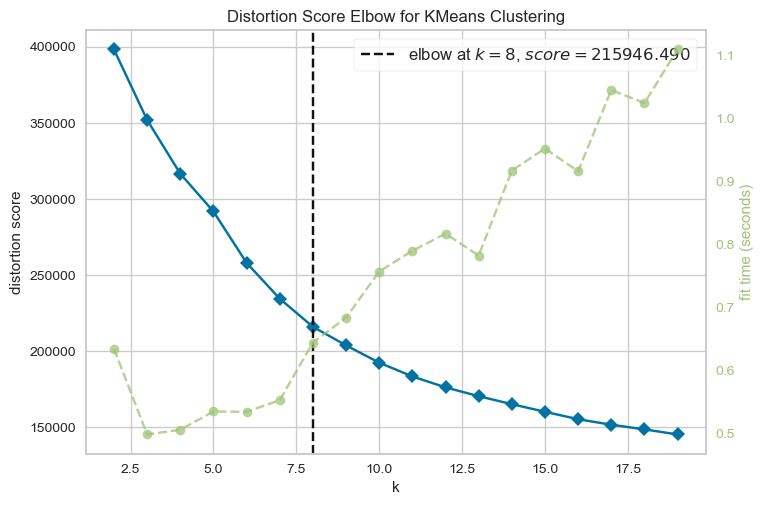

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [11]:
print('Elbow Method')
Elbow_M = KElbowVisualizer(KMeans(init = 'k-means++', random_state = 42), k=(2,20))
Elbow_M.fit(features)
Elbow_M.show()

In [12]:
# Creando el k-Means para los 8 grupos encontrados
kmeans = KMeans(n_clusters = 8, init = 'k-means++', random_state = 42) 
y_kmeans = kmeans.fit_predict(features)

In [13]:
labels = kmeans.labels_

In [14]:
def combine_cluster_labels(user_ids, labels):
    # Convert labels to a DataFrame
    labels_df = pd.DataFrame(labels)    
    # Merge user_ids DataFrame with labels DataFrame based on index
    cluster_df = pd.merge(user_ids, labels_df, left_index=True, right_index=True)
    # Rename columns to 'user' and 'cluster'
    cluster_df.columns = ['user', 'cluster']
    return cluster_df

In [15]:
combine_cluster_labels(user_ids, labels)

user  cluster
0            2        5
1            4        5
2            5        5
3            7        1
4            8        1
...        ...      ...
33896  2102054        2
33897  2102356        1
33898  2102680        2
33899  2102983        1
33900  2103039        1

[33901 rows x 2 columns]

Now, each user finds its own cluster or we can say we have created many clusters of learning communities. Learners within each community share very similar learning interests.

####  Apply PCA on user profile feature vectors to reduce dimensions

If we plot a covariance matrix of the user profile feature vectors with 14 features, we can observe that some features are actually correlated:

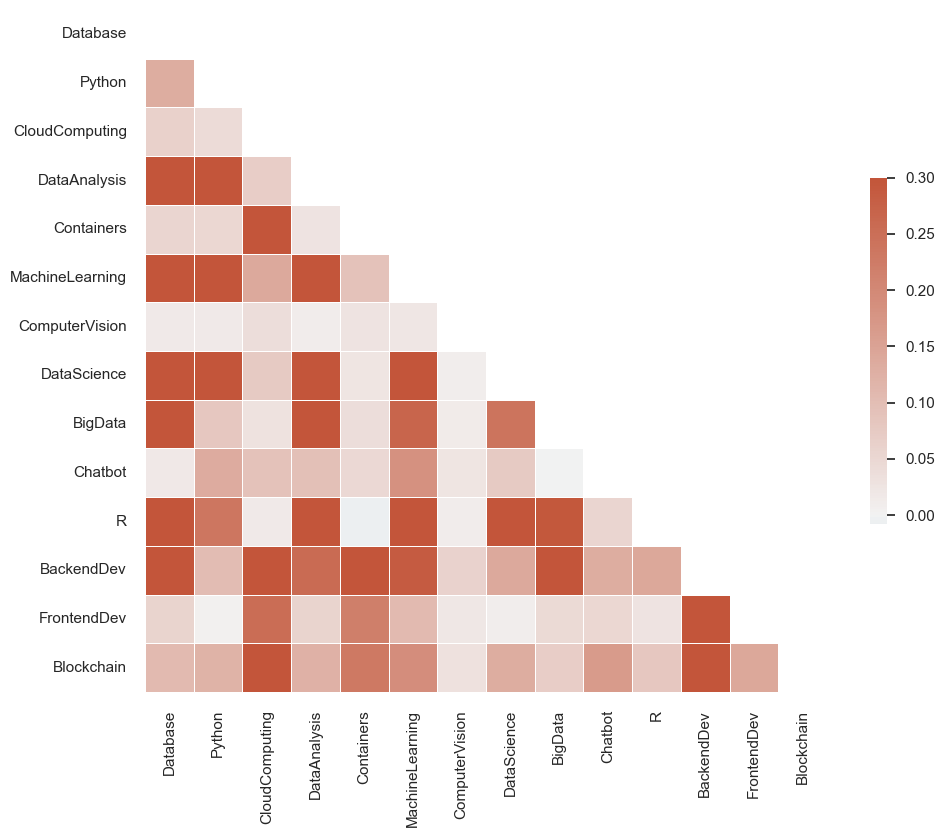

In [16]:
sns.set_theme(style="white")

# Compute the correlation matrix
corr = features.cov()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


plt.show()

For example, the feature `MachineLearning` and the feature `DataScience` are correlated. Such covariances among features may indicate that we can apply PCA to find its main components. 

If we only keep the independent main components, then we can reduce the dimensions of our user profile feature vectors.

In [17]:
pca = PCA()
PCA_ds = pd.DataFrame(pca.fit_transform(features), index=features.index, columns=[f'Component {i}' for i in range(pca.n_components_)])
PCA_ds.head()

Component 0  Component 1  Component 2  Component 3  Component 4  \
0    17.772494     0.200681     1.730609     2.567359    -3.825814   
1     7.145199    -2.847481     2.358636    -0.576654     0.398803   
2    11.363270     1.873619    -1.522077     1.076144    -1.711688   
3    -1.834033    -0.277462     0.564905     0.053470    -0.064440   
4    -1.049125    -0.684767     1.072765     0.006371    -0.005695   

   Component 5  Component 6  Component 7  Component 8  Component 9  \
0     2.707154     0.681042     2.312613     0.868272    -1.066804   
1    -0.134533     0.549769     0.469033     0.033405     0.437768   
2     0.883212     1.677582     2.937669     2.097639     0.223187   
3     0.165757     0.030956     0.039519     0.210887    -0.315553   
4     0.118686     0.118559     0.559292     0.186379    -0.680568   

   Component 10  Component 11  Component 12  Component 13  
0      0.214616      1.418811      0.513239      0.438589  
1      1.492973      1.989693      0.258151      1.297102  
2      2.635825     -0.270142      1.574101      0.362926  
3      0.087087      0.305141      0.083441      0.013351  
4      0.069248      0.187186     -0.036906     -0.013686

In [18]:
from itertools import accumulate

def plot_explained_variance(pca):
    acc = [*accumulate(pca.explained_variance_ratio_)]
    fig, ax = plt.subplots(1, figsize=(50, 20))
    ax.stackplot(range(pca.n_components_), acc)
    ax.scatter(range(pca.n_components_), acc, color='black')
    ax.set_ylim(0, 1)
    ax.set_xlim(0, pca.n_components_-1)
    ax.tick_params(axis='both', labelsize=36)
    ax.set_xlabel('N Components', fontsize=48)
    ax.set_ylabel('Accumulated explained variance', fontsize=48)
    plt.tight_layout()
    plt.show()

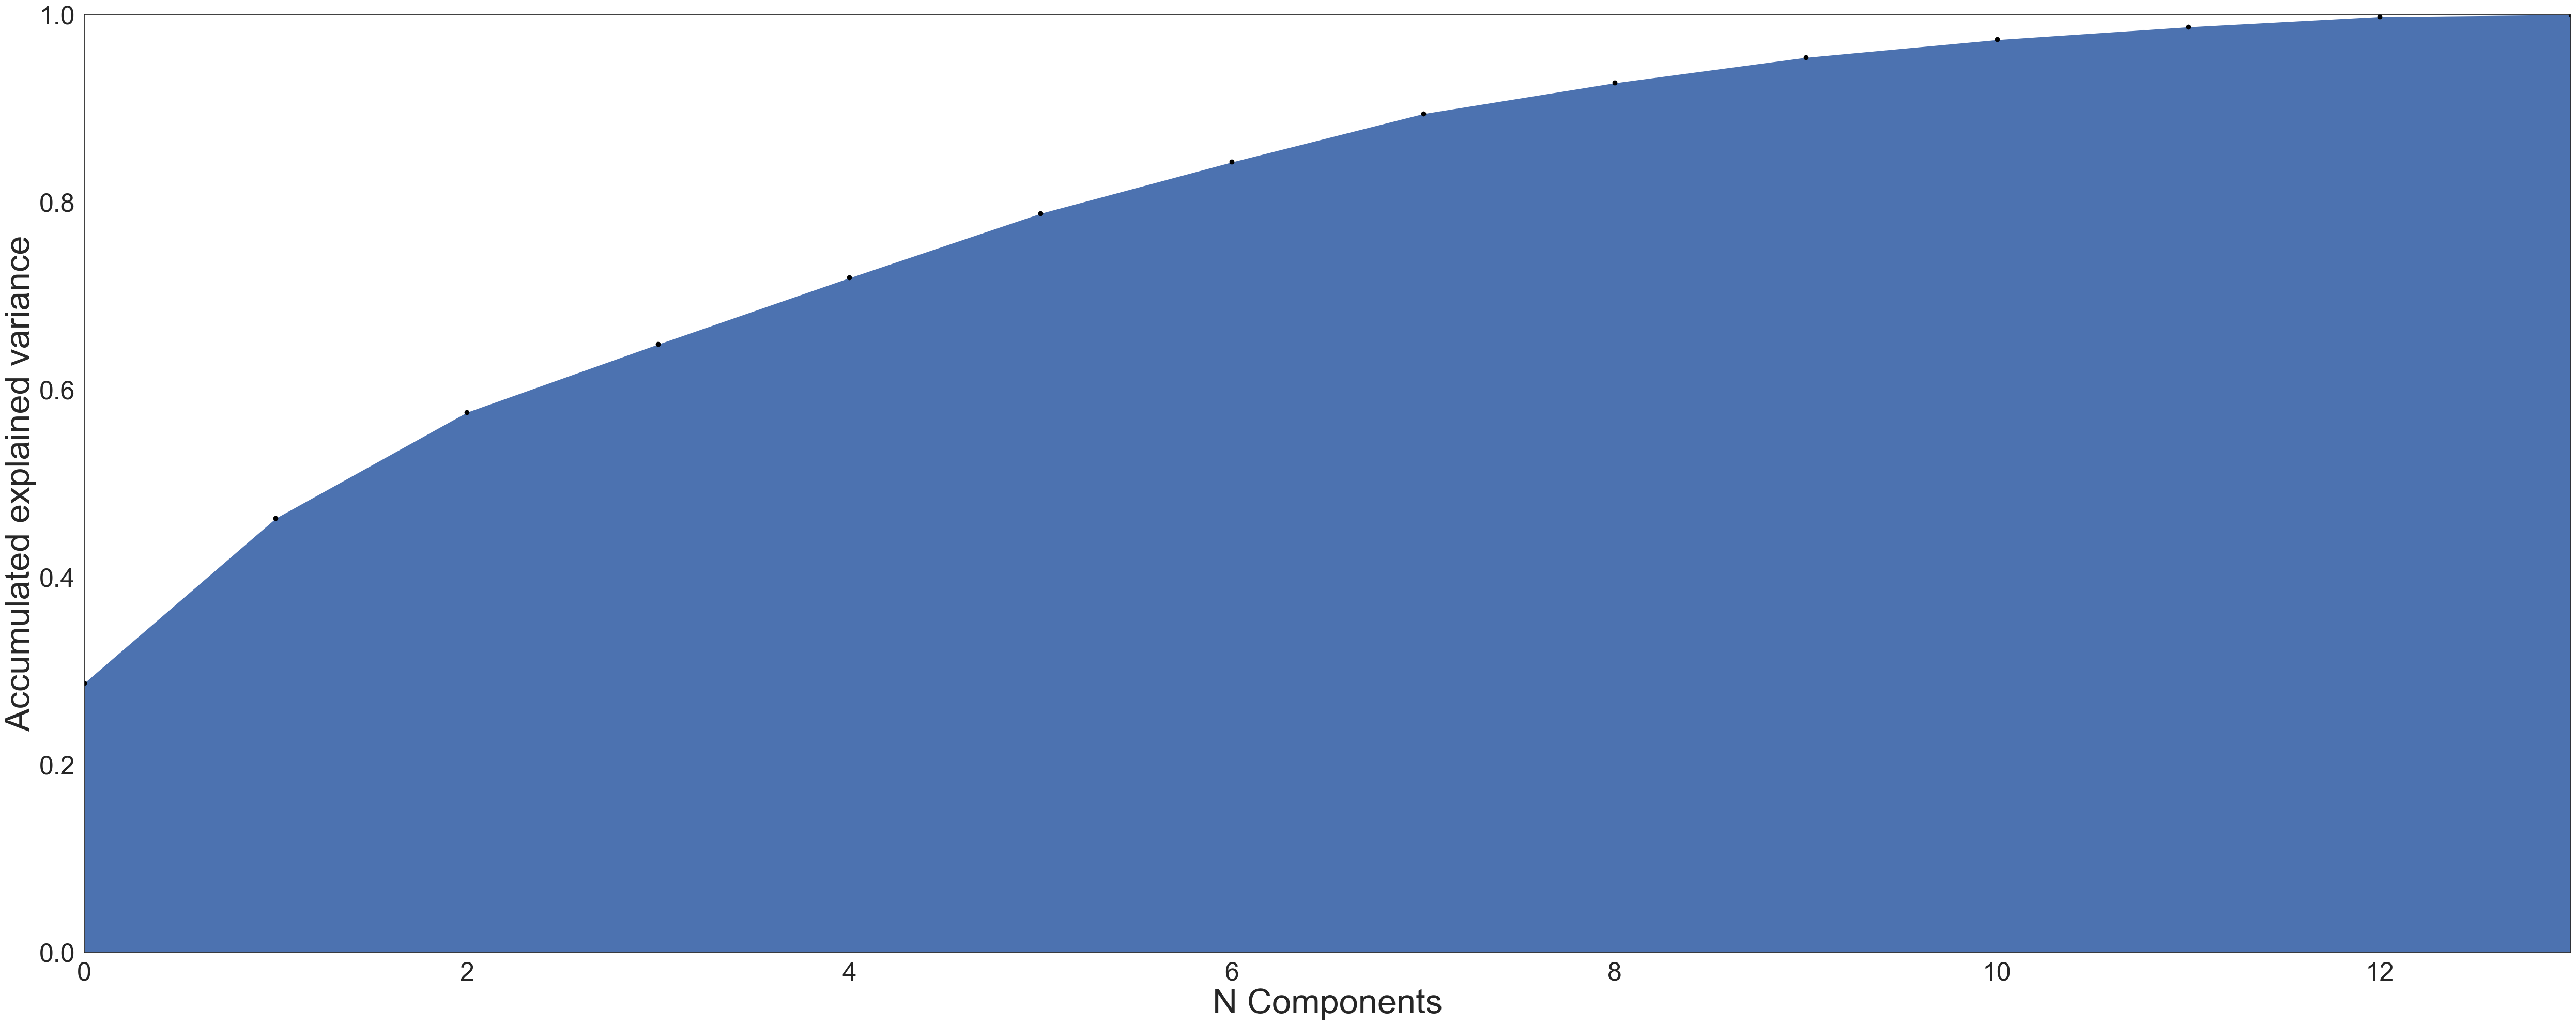

In [19]:
plot_explained_variance(pca)

In [20]:
# Nos quedamos con el 90% de varianza explicada 
threshold = 0.90
num = next(i for i, x in enumerate(accumulate(pca.explained_variance_ratio_), 1) if x >= threshold)
print(f'Podemos retener los {num} componentes y descartar {pca.n_components_-num},')
print(f'Manteniendo  >={100 * threshold}%  de la varianza explicada!')

Podemos retener los 9 componentes y descartar 5,
Manteniendo  >=90.0%  de la varianza explicada!


In [21]:
PCA_ds.drop([f'Component {i}' for i in range(num, pca.n_components_)], axis=1, inplace=True)
PCA_ds.head()

Component 0  Component 1  Component 2  Component 3  Component 4  \
0    17.772494     0.200681     1.730609     2.567359    -3.825814   
1     7.145199    -2.847481     2.358636    -0.576654     0.398803   
2    11.363270     1.873619    -1.522077     1.076144    -1.711688   
3    -1.834033    -0.277462     0.564905     0.053470    -0.064440   
4    -1.049125    -0.684767     1.072765     0.006371    -0.005695   

   Component 5  Component 6  Component 7  Component 8  
0     2.707154     0.681042     2.312613     0.868272  
1    -0.134533     0.549769     0.469033     0.033405  
2     0.883212     1.677582     2.937669     2.097639  
3     0.165757     0.030956     0.039519     0.210887  
4     0.118686     0.118559     0.559292     0.186379

In [22]:
# Merge the user ids and transformed features into a new dataframe
result_df = pd.concat([user_ids, PCA_ds], axis=1)
result_df

user  Component 0  Component 1  Component 2  Component 3  \
0            2    17.772494     0.200681     1.730609     2.567359   
1            4     7.145199    -2.847481     2.358636    -0.576654   
2            5    11.363270     1.873619    -1.522077     1.076144   
3            7    -1.834033    -0.277462     0.564905     0.053470   
4            8    -1.049125    -0.684767     1.072765     0.006371   
...        ...          ...          ...          ...          ...   
33896  2102054     0.633824     0.108815    -0.388871    -0.122665   
33897  2102356    -2.095339     0.135058     0.244727    -0.088185   
33898  2102680     0.625943    -0.547167    -1.692824    -0.630589   
33899  2102983    -2.036832    -0.153534     0.162852     0.082651   
33900  2103039    -2.036832    -0.153534     0.162852     0.082651   

       Component 4  Component 5  Component 6  Component 7  Component 8  
0        -3.825814     2.707154     0.681042     2.312613     0.868272  
1         0.398803    -0.134533     0.549769     0.469033     0.033405  
2        -1.711688     0.883212     1.677582     2.937669     2.097639  
3        -0.064440     0.165757     0.030956     0.039519     0.210887  
4        -0.005695     0.118686     0.118559     0.559292     0.186379  
...            ...          ...          ...          ...          ...  
33896    -0.098364     0.358333     1.752049     1.486542    -0.523600  
33897     0.025081     0.183641     0.046413     0.191709     0.260437  
33898     0.166632     0.676244    -0.055100     0.582091     1.703193  
33899    -0.126419     0.255109     0.072496     0.113750     0.622900  
33900    -0.126419     0.255109     0.072496     0.113750     0.622900  

[33901 rows x 10 columns]

#### Perform k-means clustering on the PCA transformed feature vectors

Elbow Method


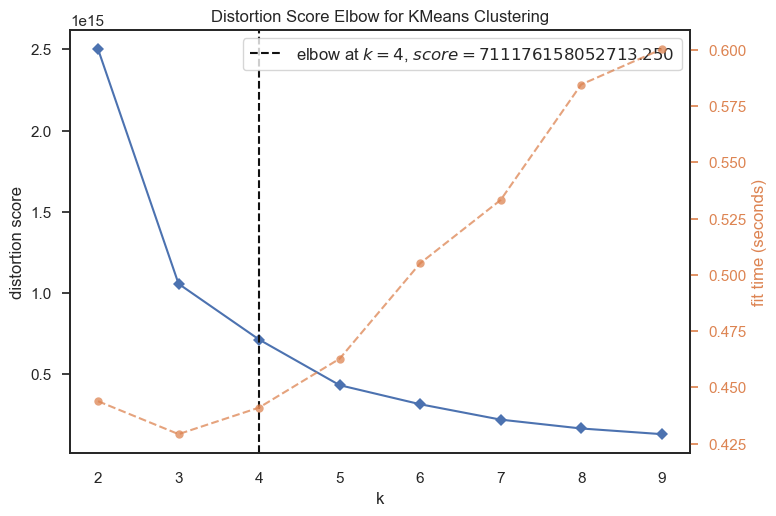

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [23]:
print('Elbow Method')
Elbow_M = KElbowVisualizer(KMeans(init = 'k-means++', random_state = 42), k=(2,10))
Elbow_M.fit(result_df)
Elbow_M.show()

In [24]:
# Creando el k-Means para los 4 grupos encontrados
kmeans_pca = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42) 
y_kmeans_pca = kmeans_pca.fit_predict(result_df)

In [25]:
user_ids["Clusters"] = y_kmeans_pca



In [26]:
user_ids.tail(5)

user  Clusters
33896  2102054         1
33897  2102356         1
33898  2102680         1
33899  2102983         1
33900  2103039         1

In [27]:
user_ids["Clusters"].unique()

array([2, 0, 3, 1])

#### Generate course recommendations based on the popular courses in the same cluster

In summary, the clustering-based recommender system first groups all users based on their profiles, and maintains a popular courses list for each group. 

For any group member who needs course recommendations, the algorithm recommends the unselected courses from the popular course lists.

Next, suppose we have a set of test users, and we want to recommend new courses to them using a clustering-based recommender system:

In [28]:
test_user_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-ML0321EN-Coursera/labs/v2/module_3/ratings.csv"

# Reading the test user data CSV file into a pandas DataFrame
# Selecting only the 'user' and 'item' columns using indexing
test_users_df = pd.read_csv(test_user_url)[['user', 'item']]

# Displaying the first few rows of the DataFrame to inspect its contents
test_users_df.head()

user        item
0  1889878    CC0101EN
1  1342067    CL0101EN
2  1990814  ML0120ENv3
3   380098    BD0211EN
4   779563    DS0101EN

In [29]:
test_users_labelled = pd.merge(test_users_df, user_ids, left_on='user', right_on='user')

In [30]:
test_users_labelled.tail(15)

user      item  Clusters
233291  1002992  BC0201EN         0
233292  2090267  DS0132EN         1
233293    24632  DS0101EN         2
233294   226549  CB0103EN         2
233295   678952  BC0201EN         0
233296   381280  CB0103EN         2
233297   280711  ML0151EN         2
233298  1673892  CNSC02EN         1
233299  1297318  DAI101EN         3
233300  1055271  BC0201EN         0
233301  1525198  CNSC02EN         3
233302  1047293  BC0201EN         0
233303  1653442  CNSC02EN         1
233304   946438  BC0201EN         0
233305   711047  CB0103EN         0

In [31]:
test_users_labelled['user'].nunique()

33901

In [32]:
# Extracting the 'item' and 'cluster' columns from the test_users_labelled DataFrame
courses_cluster = test_users_labelled[['item', 'Clusters']]

# Adding a new column 'count' with a value of 1 for each row in the courses_cluster DataFrame
courses_cluster['count'] = [1] * len(courses_cluster)

# Grouping the DataFrame by 'cluster' and 'item', aggregating the 'count' column with the sum function,
# and resetting the index to make the result more readable
courses_cluster_grouped = courses_cluster.groupby(['Clusters','item']).agg(enrollments=('count','sum')).reset_index()

In [33]:
courses_cluster_grouped.sort_values(by = 'enrollments',ascending=False)

Clusters      item  enrollments
406         3  PY0101EN         4865
4           0  BD0101EN         4573
47          0  DS0101EN         4472
86          0  PY0101EN         4435
369         3  DS0101EN         3894
..        ...       ...          ...
311         2  ST0301EN            1
255         2    DS0107            1
264         2  DX0106EN            1
266         2  DX0108EN            1
265         2  DX0107EN            1

[421 rows x 3 columns]

In [34]:
# I choose the 20 courses with the most enrolled
top_courses_per_cluster = courses_cluster_grouped.sort_values(by=['Clusters', 'enrollments'], ascending=[True, False]) \
                              .groupby('Clusters') \
                              .head(20)

In [35]:
course_genre_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/course_genre.csv"


In [36]:
course_df = pd.read_csv(course_genre_url)

In [37]:
top_courses_per_cluster = top_courses_per_cluster.merge(course_df[['COURSE_ID', 'TITLE']], how='inner', left_on='item', right_on='COURSE_ID')

In [38]:
top_courses_per_cluster

Clusters      item  enrollments COURSE_ID  \
0          0  BD0101EN         4573  BD0101EN   
1          1  BD0101EN         1817  BD0101EN   
2          2  BD0101EN         3398  BD0101EN   
3          3  BD0101EN         3503  BD0101EN   
4          0  DS0101EN         4472  DS0101EN   
..       ...       ...          ...       ...   
75         2  BD0131EN          925  BD0131EN   
76         2  BD0212EN          733  BD0212EN   
77         2  PA0101EN          717  PA0101EN   
78         3  CL0101EN         1701  CL0101EN   
79         3  CO0201EN         1354  CO0201EN   

                                               TITLE  
0                                       big data 101  
1                                       big data 101  
2                                       big data 101  
3                                       big data 101  
4                       introduction to data science  
..                                               ...  
75                           moving data into hadoop  
76                             spark fundamentals ii  
77                predictive modeling fundamentals i  
78                              ibm cloud essentials  
79  container   kubernetes essentials with ibm cloud  

[80 rows x 5 columns]

In [39]:
def recommend_courses_for_user(user_subset):
    user_id = user_subset['user'].iloc[0]
    
    #Get the courses the user is enrolled in
    enrolled_courses = set(user_subset['item'])
    
    #Find the user's cluster label
    cluster_id = user_subset['Clusters'].iloc[0]
    
    #Find all courses in the same cluster
    cluster_courses = set(top_courses_per_cluster[top_courses_per_cluster['Clusters'] == cluster_id]['item'])
    
    #Find new/unseen courses by the user
    new_courses = cluster_courses.difference(enrolled_courses)
    
    #Get the names of recommended courses
    recommended_courses = top_courses_per_cluster[top_courses_per_cluster['item'].isin(new_courses)]
    
    # Create a DataFrame with the recommendations for this user
    recommendations_df = recommended_courses[['item', 'TITLE']].copy()
    recommendations_df['user'] = user_id
    
    return recommendations_df

# Apply the function to each user group and concatenate the results
recommendations_df = test_users_labelled.groupby('user').apply(recommend_courses_for_user).reset_index(drop=True)


recommendations_df

item                                            TITLE     user
0        DS0101EN                     introduction to data science        2
1        DS0101EN                     introduction to data science        2
2        DS0101EN                     introduction to data science        2
3        DS0101EN                     introduction to data science        2
4        DS0105EN     data science hands on with open source tools        2
...           ...                                              ...      ...
1643834  CC0101EN                            introduction to cloud  2103039
1643835  DB0101EN                 sql and relational databases 101  2103039
1643836  DB0101EN                 sql and relational databases 101  2103039
1643837  CNSC02EN  cloud native security conference  data security  2103039
1643838  CC0103EN                        ibm cloud essentials   v3  2103039

[1643839 rows x 3 columns]

In [40]:
recommendations_df.drop_duplicates(inplace=True)

- On average, how many new/unseen courses have been recommended to each user?
- What are the most frequently recommended courses? Return the top-10 commonly recommended courses across all users.

In [41]:

user_recommendations_count = recommendations_df.groupby('user')['item'].count()


average_recommended_courses_per_user = user_recommendations_count.mean()


print(f"On average, {round(average_recommended_courses_per_user,0):.2f} new/unseen courses have been recommended to each user.")

On average, 15.00 new/unseen courses have been recommended to each user.


In [42]:

course_recommendation_counts = recommendations_df['item'].value_counts()


top_10_recommended_courses = course_recommendation_counts.head(10).reset_index()
top_10_recommended_courses.columns = ['item', 'recommendation_count']


top_10_recommended_courses = top_10_recommended_courses.merge(
    top_courses_per_cluster[['item', 'TITLE']], 
    on='item', 
    how='left'
).drop_duplicates()

print("Top-10 commonly recommended courses:")
top_10_recommended_courses

Top-10 commonly recommended courses:


item  recommendation_count  \
0   ST0101EN                 28886   
4   RP0101EN                 28664   
8   CB0103EN                 28389   
12  ML0115EN                 27578   
16  DS0105EN                 26702   
20  BD0211EN                 26350   
24  DS0103EN                 26182   
28  DA0101EN                 25598   
32  BD0111EN                 23302   
36  CO0101EN                 21864   

                                           TITLE  
0                                 statistics 101  
4                             r for data science  
8                         build your own chatbot  
12                             deep learning 101  
16  data science hands on with open source tools  
20                          spark fundamentals i  
24                      data science methodology  
28                     data analysis with python  
32                                    hadoop 101  
36   docker essentials  a developer introduction

## Collaborative Filtering based Recommender System using K Nearest Neighbor and  Non-negative Matrix Factorization

In [43]:
ratings_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-ML0321EN-Coursera/labs/v2/module_3/ratings.csv"

In [44]:
ratings_df = pd.read_csv(ratings_url)
ratings_df.head()

user        item  rating
0  1889878    CC0101EN       5
1  1342067    CL0101EN       3
2  1990814  ML0120ENv3       5
3   380098    BD0211EN       5
4   779563    DS0101EN       3

In [45]:
from surprise import KNNBasic
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise import NMF

In [46]:
# Save the rating dataframe to a CSV file
ratings_df.to_csv("course_ratings.csv", index=False)

# Read the course rating dataset with columns user item rating
reader = Reader(
    line_format='user item rating', sep=',', skip_lines=1, rating_scale=(2, 3))

# Load the dataset from the CSV file
course_dataset = Dataset.load_from_file("course_ratings.csv", reader=reader)

In [47]:
# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(course_dataset, test_size=.3, random_state=42)

In [48]:
print(f"Total {trainset.n_users} users and {trainset.n_items} items in the trainingset")

Total 31380 users and 124 items in the trainingset


In [49]:
# KNN
algorithms = {
    'KNNBasic pearson': KNNBasic(sim_options={'name': 'pearson_baseline', 'user_based': False}),
    'KNNBasic cosine':  KNNBasic(sim_options={'name': 'cosine', 'user_based': False}),
    'NMF': NMF(n_factors=20, n_epochs=10, random_state=123, verbose=True)
    
}


results = {
    'Algorithm': [],
    'RMSE': [],
    'MAE': [],
}

for name, algo in algorithms.items():
    
    cv_results = cross_validate(algo, course_dataset, measures=['RMSE', 'MAE'], cv=5, verbose=False)
    results['Algorithm'].append(name)
    results['RMSE'].append(np.mean(cv_results['test_rmse']))
    results['MAE'].append(np.mean(cv_results['test_mae']))

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Processing epoch 0
Processing epoch

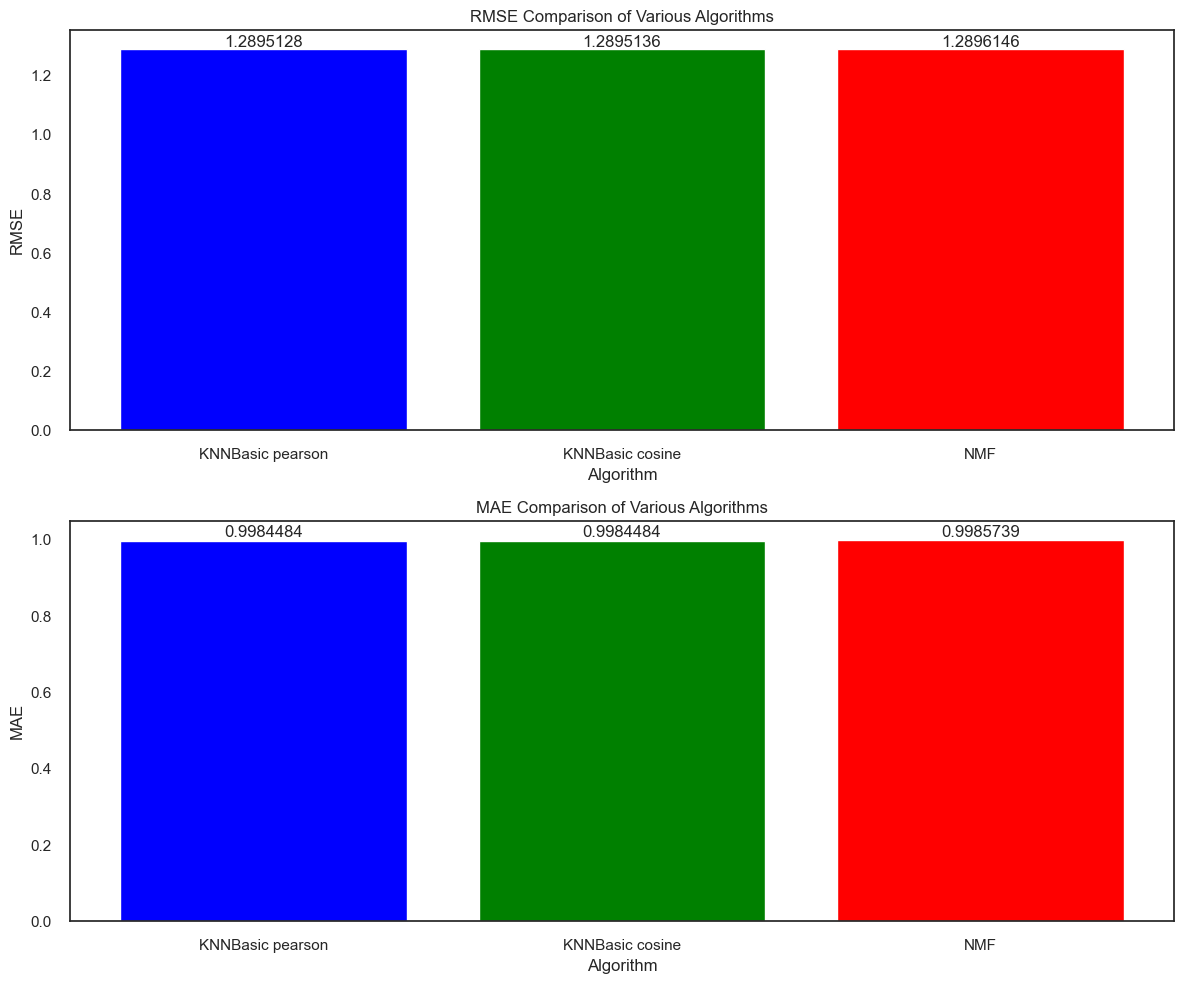

In [50]:

results_df = pd.DataFrame(results)

fig, ax = plt.subplots(2, 1, figsize=(12, 10))

ax[0].bar(results_df['Algorithm'], results_df['RMSE'], color=['blue', 'green', 'red'])
ax[0].set_xlabel('Algorithm')
ax[0].set_ylabel('RMSE')
ax[0].set_title('RMSE Comparison of Various Algorithms')
for index, value in enumerate(results_df['RMSE']):
    ax[0].text(index, value + 0.01, f"{value:.7f}", ha='center')

ax[1].bar(results_df['Algorithm'], results_df['MAE'], color=['blue', 'green', 'red'])
ax[1].set_xlabel('Algorithm')
ax[1].set_ylabel('MAE')
ax[1].set_title('MAE Comparison of Various Algorithms')
for index, value in enumerate(results_df['MAE']):
    ax[1].text(index, value + 0.01, f"{value:.7f}", ha='center')



plt.tight_layout()
plt.show()

In [51]:
results_df

Algorithm      RMSE       MAE
0  KNNBasic pearson  1.289513  0.998448
1   KNNBasic cosine  1.289514  0.998448
2               NMF  1.289615  0.998574

## Classification-based Rating Mode Prediction using Embedding Features

In [52]:
user_emb_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/user_embeddings.csv"
item_emb_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/course_embeddings.csv"

In [53]:
ratings_df.head()

user        item  rating
0  1889878    CC0101EN       5
1  1342067    CL0101EN       3
2  1990814  ML0120ENv3       5
3   380098    BD0211EN       5
4   779563    DS0101EN       3

In [54]:
# Load user embeddings
user_emb = pd.read_csv(user_emb_url)
# Load item embeddings
item_emb = pd.read_csv(item_emb_url)

In [55]:
user_emb.head()

user  UFeature0  UFeature1  UFeature2  UFeature3  UFeature4  UFeature5  \
0  1889878   0.080721  -0.129561   0.087998   0.030231   0.082691  -0.004176   
1  1342067   0.068047  -0.112781   0.045208  -0.007570  -0.038382   0.068037   
2  1990814   0.124623   0.012910  -0.072627   0.049935   0.020158   0.133306   
3   380098  -0.034870   0.000715   0.077406   0.070311  -0.043007  -0.035446   
4   779563   0.106414  -0.001887  -0.017211  -0.042277  -0.074953  -0.056732   

   UFeature6  UFeature7  UFeature8  UFeature9  UFeature10  UFeature11  \
0  -0.003480   0.091464  -0.040247   0.018958   -0.153328   -0.090143   
1   0.114949   0.104128  -0.034401   0.004011    0.064832    0.165857   
2  -0.035366  -0.156026   0.039269   0.042195    0.014695   -0.115989   
3   0.032846  -0.060944   0.112384   0.002114    0.090660   -0.068545   
4   0.074610  -0.019367  -0.031341   0.064896   -0.048158   -0.047309   

   UFeature12  UFeature13  UFeature14  UFeature15  
0    0.082830   -0.058721    0.057929   -0.001472  
1   -0.004384    0.053257    0.014308    0.056684  
2    0.031158    0.102021   -0.020601    0.116488  
3    0.008967    0.063962    0.052347    0.018072  
4   -0.007544    0.010474   -0.032287   -0.083983

In [56]:
item_emb.head()

item  CFeature0  CFeature1  CFeature2  CFeature3  CFeature4  \
0    CC0101EN   0.009657  -0.005238  -0.004098   0.016303  -0.005274   
1    CL0101EN  -0.008611   0.028041   0.021899  -0.001465   0.006900   
2  ML0120ENv3   0.027439  -0.027649  -0.007484  -0.059451   0.003972   
3    BD0211EN   0.020163  -0.011972  -0.003714  -0.015548  -0.007540   
4    DS0101EN   0.006399   0.000492   0.005640   0.009639  -0.005487   

   CFeature5  CFeature6  CFeature7  CFeature8  CFeature9  CFeature10  \
0  -0.000361  -0.015081  -0.012229   0.015686   0.008401   -0.035495   
1  -0.017981   0.010899  -0.037610  -0.019397  -0.025682   -0.000620   
2   0.020496  -0.012695   0.036138   0.019965   0.018686   -0.010450   
3   0.014847  -0.005700  -0.006068  -0.005792  -0.023036    0.015999   
4  -0.000590  -0.010015  -0.001514  -0.017598   0.003590    0.016799   

   CFeature11  CFeature12  CFeature13  CFeature14  CFeature15  
0    0.009381   -0.032560   -0.007292    0.000966   -0.006218  
1    0.038803    0.000196   -0.045343    0.012863    0.019429  
2   -0.050011    0.013845   -0.044454   -0.001480   -0.007559  
3   -0.023480    0.015469    0.022221   -0.023115   -0.001785  
4    0.002732    0.005162    0.015031   -0.000877   -0.021283

In [57]:
# Merge user embedding features
merged_df = pd.merge(ratings_df, user_emb, how='left', left_on='user', right_on='user').fillna(0)
# Merge course embedding features
merged_df = pd.merge(merged_df, item_emb, how='left', left_on='item', right_on='item').fillna(0)

In [58]:
merged_df.head()

user        item  rating  UFeature0  UFeature1  UFeature2  UFeature3  \
0  1889878    CC0101EN       5   0.080721  -0.129561   0.087998   0.030231   
1  1342067    CL0101EN       3   0.068047  -0.112781   0.045208  -0.007570   
2  1990814  ML0120ENv3       5   0.124623   0.012910  -0.072627   0.049935   
3   380098    BD0211EN       5  -0.034870   0.000715   0.077406   0.070311   
4   779563    DS0101EN       3   0.106414  -0.001887  -0.017211  -0.042277   

   UFeature4  UFeature5  UFeature6  ...  CFeature6  CFeature7  CFeature8  \
0   0.082691  -0.004176  -0.003480  ...  -0.015081  -0.012229   0.015686   
1  -0.038382   0.068037   0.114949  ...   0.010899  -0.037610  -0.019397   
2   0.020158   0.133306  -0.035366  ...  -0.012695   0.036138   0.019965   
3  -0.043007  -0.035446   0.032846  ...  -0.005700  -0.006068  -0.005792   
4  -0.074953  -0.056732   0.074610  ...  -0.010015  -0.001514  -0.017598   

   CFeature9  CFeature10  CFeature11  CFeature12  CFeature13  CFeature14  \
0   0.008401   -0.035495    0.009381   -0.032560   -0.007292    0.000966   
1  -0.025682   -0.000620    0.038803    0.000196   -0.045343    0.012863   
2   0.018686   -0.010450   -0.050011    0.013845   -0.044454   -0.001480   
3  -0.023036    0.015999   -0.023480    0.015469    0.022221   -0.023115   
4   0.003590    0.016799    0.002732    0.005162    0.015031   -0.000877   

   CFeature15  
0   -0.006218  
1    0.019429  
2   -0.007559  
3   -0.001785  
4   -0.021283  

[5 rows x 35 columns]

In [59]:
merged_df['rating'].value_counts() # we only have 3 ratings

4    77936
3    77866
5    77504
Name: rating, dtype: int64

In [60]:
u_feautres = [f"UFeature{i}" for i in range(16)] # Assuming there are 16 user embedding features
c_features = [f"CFeature{i}" for i in range(16)] # Assuming there are 16 course embedding features
# Extract user embedding features
user_embeddings = merged_df[u_feautres]
# Extract course embedding features
course_embeddings = merged_df[c_features]
# Extract ratings
ratings = merged_df['rating']

# Aggregate the two feature columns using element-wise add
interaction_dataset = user_embeddings + course_embeddings.values
# Rename the columns of the resulting DataFrame
interaction_dataset.columns = [f"Feature{i}" for i in range(16)]
# Add the 'rating' column from the original DataFrame 
interaction_dataset['rating'] = ratings
# Display the first few rows of the regression dataset
interaction_dataset.head()

Feature0  Feature1  Feature2  Feature3  Feature4  Feature5  Feature6  \
0  0.090378 -0.134799  0.083900  0.046534  0.077417 -0.004537 -0.018561   
1  0.059437 -0.084740  0.067107 -0.009036 -0.031482  0.050057  0.125847   
2  0.152061 -0.014739 -0.080112 -0.009516  0.024130  0.153802 -0.048061   
3 -0.014707 -0.011257  0.073692  0.054763 -0.050547 -0.020599  0.027146   
4  0.112812 -0.001395 -0.011572 -0.032638 -0.080440 -0.057321  0.064595   

   Feature7  Feature8  Feature9  Feature10  Feature11  Feature12  Feature13  \
0  0.079236 -0.024561  0.027359  -0.188823  -0.080762   0.050271  -0.066013   
1  0.066517 -0.053798 -0.021671   0.064212   0.204660  -0.004188   0.007914   
2 -0.119888  0.059234  0.060882   0.004244  -0.166000   0.045002   0.057566   
3 -0.067012  0.106593 -0.020921   0.106658  -0.092025   0.024436   0.086183   
4 -0.020880 -0.048939  0.068486  -0.031359  -0.044577  -0.002381   0.025505   

   Feature14  Feature15  rating  
0   0.058894  -0.007689       5  
1   0.027170   0.076114       3  
2  -0.022081   0.108929       5  
3   0.029232   0.016287       5  
4  -0.033164  -0.105266       3

In [61]:
from sklearn.preprocessing import LabelEncoder

In [62]:
# Extract features (X) from the interaction_dataset DataFrame
# Selects all rows and all columns except the last column (features)
X = interaction_dataset.iloc[:, :-1]
# Extract the target variable (y_raw) from the interaction_dataset DataFrame
# Selects all rows and only the last column (target variable)
y_raw = interaction_dataset.iloc[:, -1]
# Initialize a LabelEncoder object to encode the target variable
label_encoder = LabelEncoder()
# Encode the target variable (y_raw) using the LabelEncoder
# .values.ravel() converts the target variable to a flattened array before encoding
# The LabelEncoder fits and transforms the target variable, assigning encoded labels to y
y = label_encoder.fit_transform(y_raw.values.ravel())



In [63]:
np.unique(y)

array([0, 1, 2], dtype=int64)

In [64]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

##### Logistic Regression

In [66]:
log_reg = LogisticRegression(max_iter=1000, multi_class='multinomial')

In [67]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'saga']
}


grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)


best_model = grid_search.best_estimator_



In [68]:
best_model 

LogisticRegression(C=10, max_iter=1000, multi_class='multinomial',
                   solver='newton-cg')

In [69]:
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)


print(f'Best Parameters: {grid_search.best_params_}')
print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)



Best Parameters: {'C': 10, 'solver': 'newton-cg'}
Accuracy: 0.33458109498228367
Confusion Matrix:
[[ 7066 11702  4761]
 [ 6950 11547  4737]
 [ 7092 11332  4805]]
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.30      0.32     23529
           1       0.33      0.50      0.40     23234
           2       0.34      0.21      0.26     23229

    accuracy                           0.33     69992
   macro avg       0.33      0.33      0.32     69992
weighted avg       0.33      0.33      0.32     69992



In [70]:
cross_val_scores = cross_val_score(best_model, X, y, cv=10, scoring='accuracy')
print(f'Cross-Validation Accuracy: {cross_val_scores.mean()} ± {cross_val_scores.std()}')

Cross-Validation Accuracy: 0.3326703581508723 ± 0.003138848583058128


The model has a low overall accuracy (33.46%), indicating that it is not performing well in classifying the instances into the three classes.
Class 1 has the best recall (50%), but its precision is still low.
The metrics for classes 0 and 2 are even lower, especially in recall for class 2 (21%).

##### XGBoost

Let's try a more complex model:

In [71]:
xgb_model = xgb.XGBClassifier(objective='multi:softmax')



In [72]:
xgb_model.fit(X_train, y_train)





XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [73]:
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)


print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)


cross_val_scores = cross_val_score(xgb_model, X, y, cv=10, scoring='accuracy')
print(f'Cross-Validation Accuracy: {cross_val_scores.mean()} ± {cross_val_scores.std()}')

Accuracy: 0.33298091210424047
Confusion Matrix:
[[7455 8409 7665]
 [7366 8408 7460]
 [7482 8304 7443]]
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.32      0.33     23529
           1       0.33      0.36      0.35     23234
           2       0.33      0.32      0.33     23229

    accuracy                           0.33     69992
   macro avg       0.33      0.33      0.33     69992
weighted avg       0.33      0.33      0.33     69992

Cross-Validation Accuracy: 0.33340760283853993 ± 0.002567211774138049
